In [12]:
# import the required Libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
from matplotlib.patches import Patch
from matplotlib import patheffects as PathEffects

Read the CSV File with Polygon Data

In [13]:
df = pd.read_csv('Data\\2021_Federal_Census__Neighbourhoods_as_of_Official_Census_Day_20231228.csv')

Clean up data and rename colums

In [14]:
# Rename columns
df.rename(columns={
    'the_geom': 'polygon_data',
    'descriptiv': 'neighbourhood_name',
    'neighbourh': 'neighbourhood_id',
    # Add other columns here as necessary
}, inplace=True)

# Clean up 'neighbourhood_name' by stripping leading and trailing spaces
df['neighbourhood_name'] = df['neighbourhood_name'].str.strip()

# Convert 'neighbourhood_id' to an integer
# Ensure the column doesn't contain non-numeric values before converting
df['neighbourhood_id'] = pd.to_numeric(df['neighbourhood_id'], errors='coerce').fillna(0).astype(int)

# Only keep required colums
df = df[['polygon_data', 'neighbourhood_name', 'neighbourhood_id']]


Convert the column "the_geom" colum in the CSV to geometry type for geopandas

In [15]:
# Convert the 'polygon_data' column from WKT to actual geometry objects
df['polygon_data'] = df['polygon_data'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='polygon_data')

Assign Colors and Numbers to descriptiv column

In [16]:
# Assign a unique color and number to each 'descriptiv' value.
# Assign a unique number to each neighborhood
gdf['number'] = gdf['neighbourhood_name'].factorize()[0] + 1

# Create a color map
num_unique_neighborhoods = gdf['number'].nunique()
colors = plt.cm.viridis(range(num_unique_neighborhoods))

# Map colors to the numbers
color_map = {row['number']: (row['neighbourhood_name'], colors[i]) for i, row in gdf[['number', 'neighbourhood_name']].drop_duplicates().iterrows()}

Visualize the Multi-Polygons for each Neighbourhood

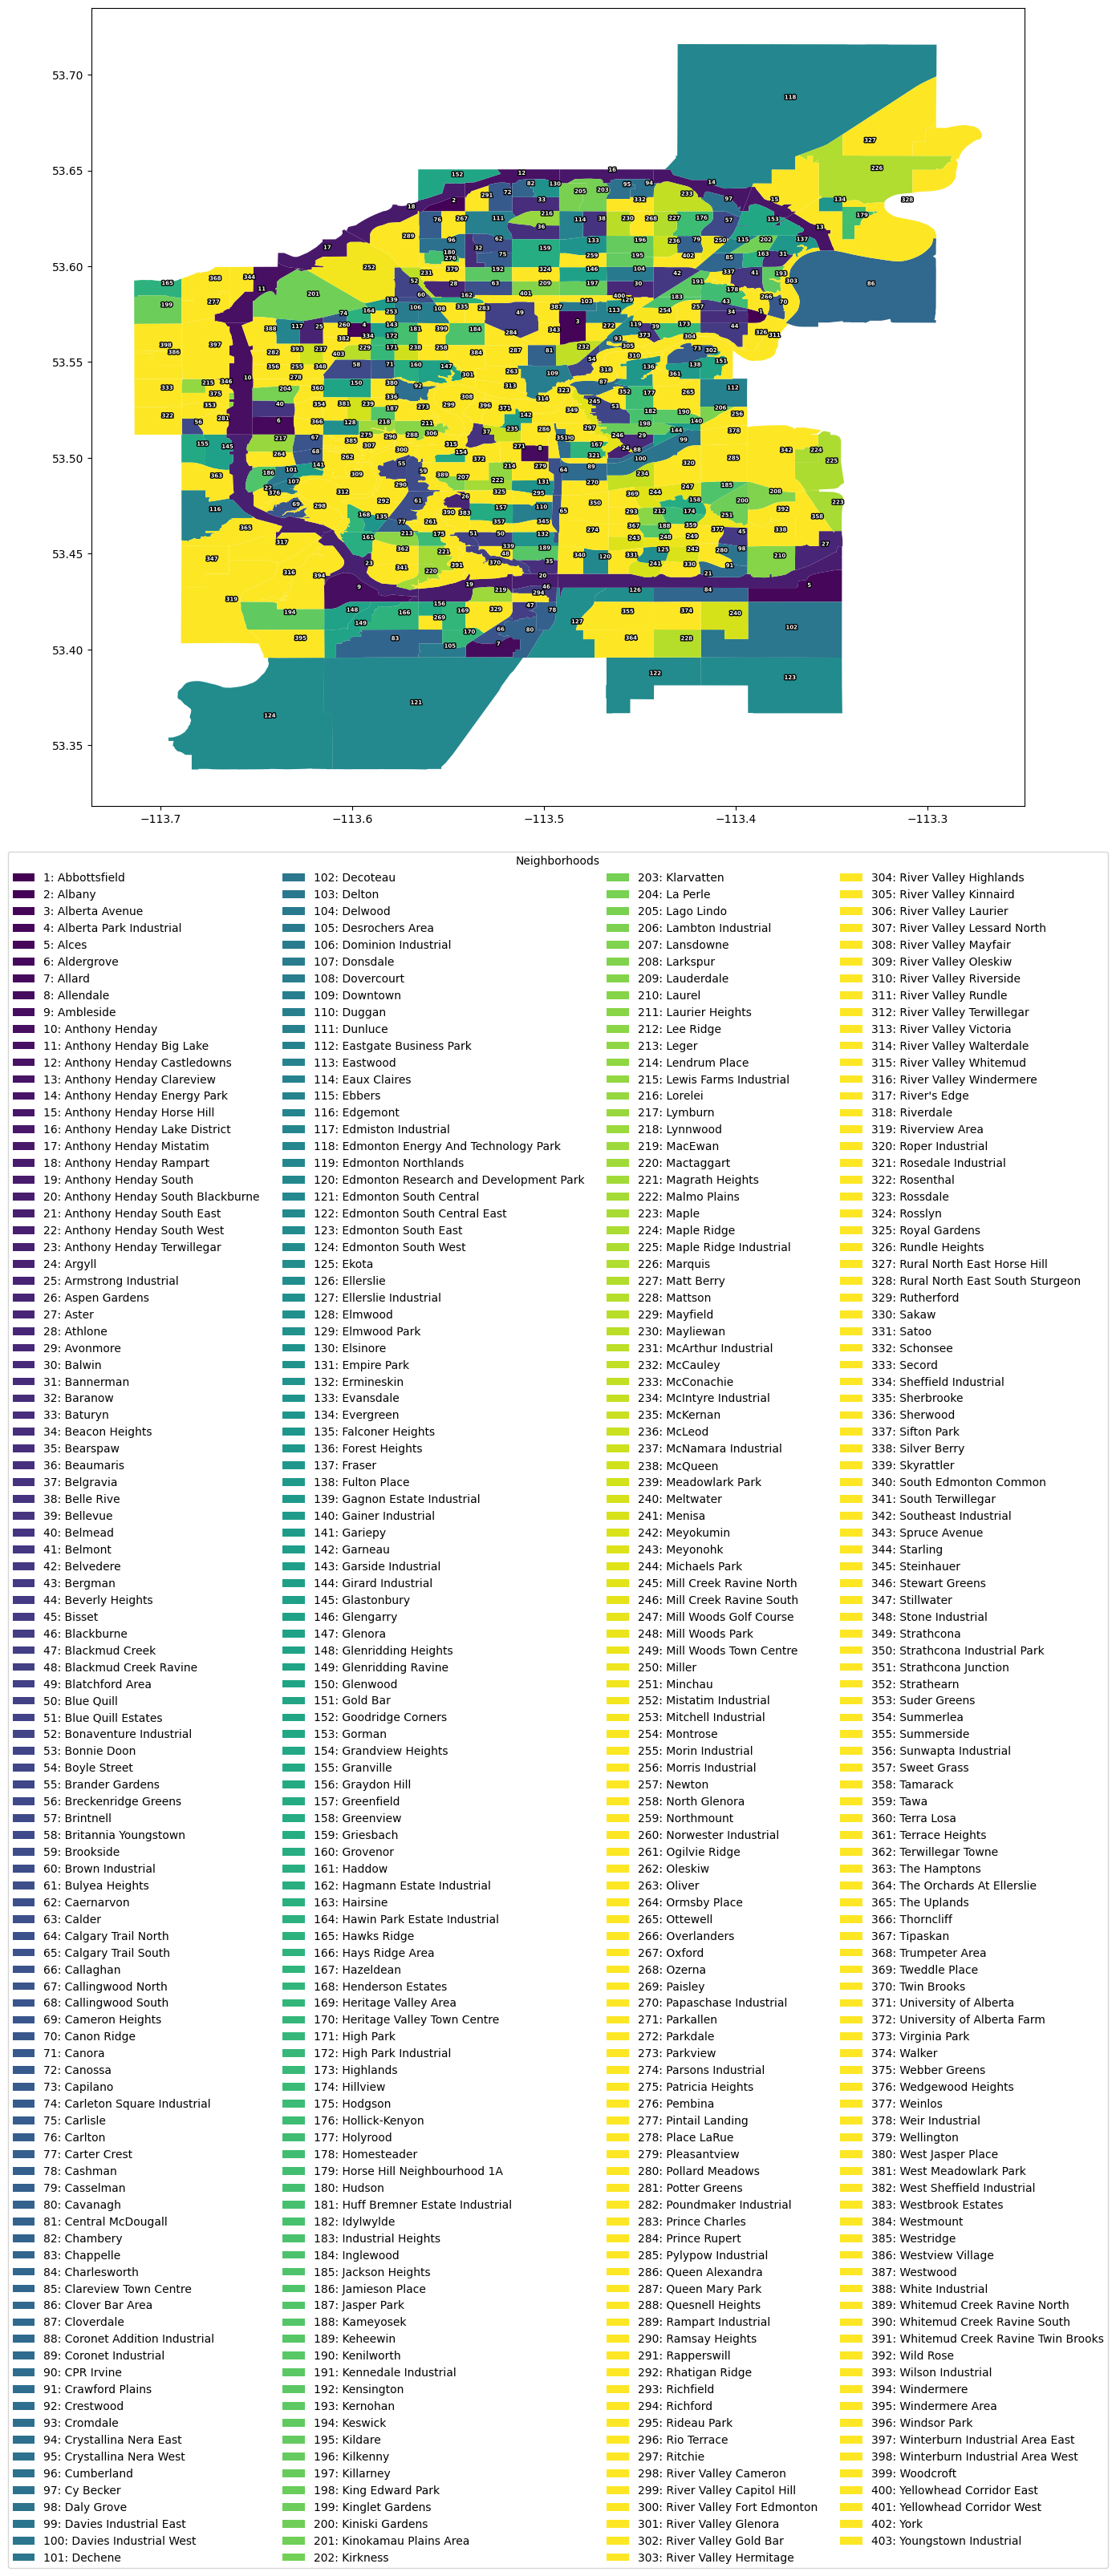

In [17]:
# Initialize the figure and axis with more space and constrained layout
fig, ax = plt.subplots(1, 1, figsize=(15, 15), constrained_layout=False)

# Plotting the geometries with colors
for number, (name, color) in color_map.items():
    subset = gdf[gdf['number'] == number]
    subset.plot(ax=ax, color=color)

# Adding labels with the number for each neighborhood
for x, y, number in zip(gdf.geometry.centroid.x, gdf.geometry.centroid.y, gdf['number']):
    ax.annotate(str(number), xy=(x, y), xytext=(3, 3), textcoords="offset points", 
                fontsize=5, color='white', weight='bold', 
                path_effects=[PathEffects.withStroke(linewidth=2, foreground="black")])

# Create a custom legend with color, number, and name below the plot
legend_patches = [Patch(facecolor=color, label=f"{number}: {name}") for number, (name, color) in color_map.items()]
ax.legend(handles=legend_patches, title='Neighborhoods', loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)

plt.show()